<a href="https://colab.research.google.com/github/mkhfring/travellingSalesMan/blob/main/TSP_Cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

1.   **GPU Runtime**: click on the "Runtime" menu item in the top bar and select the "Change runtime type" option. Select "GPU" from the list of Hardware accelerators and click "Ok".  

2.   CUDA Compilation: we will use of the NVCC4Jupyter plugin which effectively turns any Colab Notebook code block that includes `%%cu` into compilable/runnable CUDA code.

In [ ]:
# first run this to install and load nvcc plugin 
!pip install git+https://github.com/engasa/nvcc4jupyter.git
%load_ext nvcc_plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/engasa/nvcc4jupyter.git to /tmp/pip-req-build-6y1to95e
  Running command git clone -q https://github.com/engasa/nvcc4jupyter.git /tmp/pip-req-build-6y1to95e
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4406 sha256=cc90c7f9bbbcb1a331693bfae94a792465c78c3c61239b5d4c35db0777806cd1
  Stored in directory: /tmp/pip-ephem-wheel-cache-xdivgnbs/wheels/36/86/36/c7b00095a61c28f9bf69a386c706b14b45c600ce89dc6c16b2
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out




3.   Now you can check your CUDA installation by running the command below. The output should show you some info about the Cuda compiler, e.g., "*nvcc: NVIDIA (R) Cuda compiler driver Copyright (c) 2005-2021* ...etc"

In [ ]:
# check nvcc version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


4.   You can also check if GPU has been allocated. Colab notebooks without a GPU technically have access to NVCC and will compile and execute CPU/Host code, however, GPU/Device code will silently fail. To prevent such situations, this code will warn the user.


In [ ]:
%%cu
#include <stdio.h>
#include "device_launch_parameters.h"
int main() {
    int count;
    cudaGetDeviceCount(&count);
    if (count <= 0 || count > 100)  printf("!!!!! WARNING<-: NO GPU DETECTED ON THIS COLLABORATE INSTANCE. YOU SHOULD CHANGE THE RUNTIME TYPE.!!!!!\n");
    else                            printf("^^^^ GPU ENABLED! ^^^^\n");
    return 0;
}

^^^^ GPU ENABLED! ^^^^



In [ ]:
%%cu

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <iostream>
#include <string>
#include <stdint.h>

#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#define MAX_THREADS 1024
#define MAX_BLOCKS 30
#define MAX_PERMS 5041

#define CHK(x_) {cudaError_t cudaStatus = x_; if (cudaStatus != cudaSuccess) {fprintf(stderr, "Error  %d - %s\n", cudaStatus, cudaGetErrorString(cudaStatus)); goto Error;}}
#define SAFE(x_) {if((x_) == NULL) printf("out of memory. %d\n", __LINE__);}



//For host functions
__host__ unsigned long long factorial(int32_t n);
//_host__ void initialize(int8_t * city_ids, int8_t * graphWeights, int32_t size);

__host__ unsigned long long factorial(int32_t n) {
	int c;
	unsigned long long result = 1;

	for (c = 1; c <= n; c++){
		result = result * c;
  }

	return result;
}

__host__
void initialize(int8_t * city_ids, int8_t * graphWeights, int32_t size) {
	for (int i = 0; i < size; i++) {
		city_ids[i] = i;
		for (int j = 0; j < size; j++) {
			if (i == j)
				graphWeights[i * size + j] = 0;
			else
				graphWeights[i * size + j] = 99;
		}
	}

	for (int i = 0; i < size; i++) {
		for (int j = 0; j < size;) {
			int next = 1; // (rand() % 2) + 1;
			int road = rand() % 100 + 1;
			if (i == j) {
				j += next;
				continue;
			}
			graphWeights[i * size + j] = road;
			j += next;
		}
	}

	for (int i = size - 1; i >= 0; i--) {
		graphWeights[((i + 1) % size) * size + i] = 1;
	}
  for(int i=0; i<size; i++){
      for(int j=0; j<size; j++){
          printf("%d,\t", graphWeights[i * size + j]);
      }
      printf("\n");
  }
}


__host__
void print_Graph(int8_t * graphWeights, int32_t size) {
	int i, j;
	for (i = 0; i < size; i++) {
		for (j = 0; j < size; j++) {
			printf("%d\t", graphWeights[i * size + j]);
		}
		printf("\n");
	}
}

__host__
void print_ShortestPath(int8_t * shortestPath, int32_t cost, int32_t size) {
	int i;
	if (cost == (size * 100)) printf("no possible path found.\n");
	else {
		for (i = 0; i < size; i++) {
			printf("%d\t", shortestPath[i]);
		}
		printf("\nCost: %d\n", cost);
	}
}


//For device functions
__device__ __shared__ int32_t shared_cost;

__device__
void coppy_array(int8_t * path, int8_t * shortestPath, int32_t * tcost, int8_t * weights, int8_t length, int tid) {
	int32_t sum = 0;
	for (int32_t i = 0; i < length; i++) {
		int8_t val = weights[path[i] * length + path[(i + 1) % length]];
		if (val == -1) return;
		sum += val;
	}
	if (sum == 0) return;
	atomicMin(&shared_cost, sum);
	if (shared_cost == sum) {
		*tcost = sum;
		memcpy(shortestPath, path, length * sizeof(int32_t));
	}
}

__device__
void swap(int8_t *x, int8_t *y) { int8_t tmp = *x; *x = *y;	*y = tmp; }

__device__
void reverse(int8_t *first, int8_t *last) { while ((first != last) && (first != --last)) swap(first++, last); }


__device__
bool next_permutation(int8_t * first, int8_t * last) {
	if (first == last) return false;
	int8_t * i = first;
	++i;
	if (i == last) return false;
	i = last;
	--i;

	for (;;) {
		int8_t * ii = i--;
		if (*i < *ii) {
			int8_t * j = last;
			while (!(*i < *--j));
			swap(i, j);
			reverse(ii, last);
			return true;
		}
		if (i == first) {
			reverse(first, last);
			return false;
		}
	}
}



__global__
void find_permutations_for_threads(int8_t * city_ids, int8_t * k, int8_t * choices, int32_t * size, unsigned long long * threads_per_kernel) {

  int32_t length = *size;
	int8_t index = 1;
	unsigned long long count = 0;
	for (count = 0; count < *threads_per_kernel; count++) {
		for (int i = 0; i < length; i++) {
			choices[i + count * length] = city_ids[i];
		}
		reverse(city_ids + *k + index, city_ids + length);
	}

}

__global__
void combinations_kernel(int8_t * choices, int8_t * k, int8_t * shortestPath, int8_t * graphWeights, int32_t * cost, int32_t * size) {
    
	uint32_t tid = threadIdx.x + blockIdx.x * blockDim.x;
	int32_t length = *size;
	int8_t index = 1;

	/* local variables */
	int8_t * _path, *_shortestPath;
	int32_t _tcost;

	SAFE(_path = (int8_t *)malloc(length * sizeof(int8_t)));
	SAFE(_shortestPath = (int8_t *)malloc(length * sizeof(int8_t)));
	_tcost = length * 100;

	memcpy(_path, choices + tid * length, length * sizeof(int8_t));
	memcpy(_shortestPath, shortestPath, length * sizeof(int8_t));

	if (threadIdx.x == 0) {
		if (cost[blockIdx.x] == 0) cost[blockIdx.x] = length * 100;
		shared_cost = length * 100;
	}

	__syncthreads();

	do {
		coppy_array(_path, _shortestPath, &_tcost, graphWeights, length, tid);
	} while (next_permutation(_path + *k + index, _path + length));

	if (_tcost == shared_cost) {
		atomicMin(&cost[blockIdx.x], _tcost);
		if (cost[blockIdx.x] == _tcost) {
			memcpy(shortestPath + blockIdx.x * length, _shortestPath, length * sizeof(int8_t));
		}
	}

	free(_path);
	free(_shortestPath);
}


int main() {
		int size8 = sizeof(int8_t);
		int size32 = sizeof(int32_t);
	unsigned long long total_permutations, thread_perms, num_blocks = 1, num_threads, num_kernels = 1;
	float time_passed;
	cudaEvent_t startEvent, stopEvent;
	/* host variables */
	int8_t * city_ids, *shortestPath, *graphWeights, *choices;
  int32_t size, *cost;
	float time_track[6];
	int track_index = 0;
	for (int sizeIndex=4; sizeIndex<17; sizeIndex+=2){
	size = sizeIndex;
	printf("The size is %d\n", size);
	int8_t selected_K = 0;
	unsigned long long threads_per_kernel;
	/* device variables */
	int8_t * dev_city_ids, *dev_shortestPath, *dev_graphWeights, *dev_choices;
	int32_t * dev_cost, *dev_size;
	int8_t * dev_selected_K;
	unsigned long long * dev_threads_per_kernel;

	total_permutations = factorial(size - 1);
	printf("factorial(%d): %llu\n", size - 1, total_permutations);

	for (selected_K = 1; selected_K < size - 2; selected_K++) {
		thread_perms = factorial(size - 1 - selected_K);
		if (thread_perms < MAX_PERMS) break;
	}
  
	num_threads = total_permutations / thread_perms;
	int k;
	while (num_threads > MAX_THREADS) {
		k = 2;
		while (num_threads % k != 0) k++;
		num_threads /= k;
		num_blocks *= k;
	}
	while (num_blocks > MAX_BLOCKS) {
		k = 2;
		while (num_blocks % k != 0) k++;
		num_blocks /= k;
		num_kernels *= k;
	}
	threads_per_kernel = num_blocks * num_threads;

	dim3 block_dim(num_threads, 1, 1);
	dim3 grid_dim(num_blocks, 1, 1);
  SAFE(city_ids = (int8_t *)malloc(size * size8));
	SAFE(shortestPath = (int8_t *)calloc(num_blocks * size, size8));
	SAFE(graphWeights = (int8_t *)malloc(size * size8 * size));
	SAFE(cost = (int32_t *)calloc(num_blocks * size, size32));
	SAFE(choices = (int8_t *)malloc(threads_per_kernel * size * size8));

  CHK(cudaMalloc((void **)&dev_city_ids, size * size8));
	CHK(cudaMalloc((void **)&dev_shortestPath, size * size8 * num_blocks));
	CHK(cudaMalloc((void **)&dev_graphWeights, size * size8 * size));
	CHK(cudaMalloc((void **)&dev_cost, num_blocks * size32));
	CHK(cudaMalloc((void **)&dev_size, size32));
	CHK(cudaMalloc((void **)&dev_selected_K, size8));
	CHK(cudaMalloc((void **)&dev_choices, threads_per_kernel * size * size8));
	CHK(cudaMalloc((void **)&dev_threads_per_kernel, sizeof(unsigned long long)));

  srand(time(NULL));
	initialize(city_ids, graphWeights, size);

	CHK(cudaMemcpy(dev_city_ids, city_ids, size * size8, cudaMemcpyHostToDevice));
	CHK(cudaMemcpy(dev_shortestPath, shortestPath, size * size8 * num_blocks, cudaMemcpyHostToDevice));
	CHK(cudaMemcpy(dev_graphWeights, graphWeights, size * size8 * size, cudaMemcpyHostToDevice));
	CHK(cudaMemcpy(dev_size, &size, size32, cudaMemcpyHostToDevice));
	CHK(cudaMemcpy(dev_selected_K, &selected_K, size8, cudaMemcpyHostToDevice));
	CHK(cudaMemcpy(dev_choices, choices, threads_per_kernel * size * size8, cudaMemcpyHostToDevice));
	CHK(cudaMemcpy(dev_threads_per_kernel, &threads_per_kernel, sizeof(unsigned long long), cudaMemcpyHostToDevice));
	CHK(cudaMemcpy(dev_cost, cost, num_blocks * size32, cudaMemcpyHostToDevice));

	CHK(cudaMemcpy(dev_city_ids, city_ids, size * size8, cudaMemcpyHostToDevice));
  CHK(cudaMemcpy(dev_shortestPath, shortestPath, size * size8 * num_blocks, cudaMemcpyHostToDevice));
	CHK(cudaMemcpy(dev_graphWeights, graphWeights, size * size8 * size, cudaMemcpyHostToDevice));
	CHK(cudaMemcpy(dev_size, &size, size32, cudaMemcpyHostToDevice));
  CHK(cudaMemcpy(dev_selected_K, &selected_K, size8, cudaMemcpyHostToDevice));
	CHK(cudaMemcpy(dev_choices, choices, threads_per_kernel * size * size8, cudaMemcpyHostToDevice));
  CHK(cudaMemcpy(dev_threads_per_kernel, &threads_per_kernel, sizeof(unsigned long long), cudaMemcpyHostToDevice));
  CHK(cudaMemcpy(dev_cost, cost, num_blocks * size32, cudaMemcpyHostToDevice));


	CHK(cudaEventCreate(&startEvent));
	CHK(cudaEventCreate(&stopEvent));
	CHK(cudaEventRecord(startEvent, 0));
	float percentage;
	for (int i = 0; i < num_kernels; i++) {
		find_permutations_for_threads << < 1, 1 >> >(dev_city_ids, dev_selected_K, dev_choices, dev_size, dev_threads_per_kernel);
    CHK(cudaGetLastError());
		CHK(cudaDeviceSynchronize());
    combinations_kernel << < grid_dim, block_dim >> > (dev_choices, dev_selected_K, dev_shortestPath, dev_graphWeights, dev_cost, dev_size);
		CHK(cudaGetLastError());
		CHK(cudaDeviceSynchronize());
    percentage = (100. / (float) num_kernels * (float)(i + 1));
		printf("\rProgress : ");
		for (int j = 0; j < 10; j++) {
			if ((percentage / 10) / j > 1) printf("#");
			else printf(" ");
		}
		printf(" [%.2f%%]", percentage);
		fflush(stdout);
	}
	CHK(cudaEventRecord(stopEvent, 0));
	CHK(cudaEventSynchronize(stopEvent));
	CHK(cudaEventElapsedTime(&time_passed, startEvent, stopEvent));
  CHK(cudaMemcpy(shortestPath, dev_shortestPath, num_blocks * size * size8, cudaMemcpyDeviceToHost));
	CHK(cudaMemcpy(cost, dev_cost, num_blocks * size32, cudaMemcpyDeviceToHost));

  printf("\nTime passed:  %3.1f ms \n\n", time_passed);
	time_track[track_index] = time_passed;
	track_index++;
	print_Graph(graphWeights, size);

	{
		int32_t min = cost[0];
		int8_t index = 0;
		for (int i = 1; i < num_blocks; i++) {
			if (cost[i] < min) {
				min = cost[i];
				index = i;
			}
		}
		printf("Shortest path found on block #%d:\n\n", index + 1);
		print_ShortestPath(&shortestPath[index * size], min, size);
	}


  Error:
	free(city_ids);
	free(shortestPath);
	free(graphWeights);
	free(cost);
	free(choices);

	cudaFree(dev_city_ids);
	cudaFree(dev_shortestPath);
	cudaFree(dev_graphWeights);
	cudaFree(dev_cost);
	cudaFree(dev_size);
	cudaFree(dev_selected_K);
	cudaFree(dev_choices);
	cudaFree(dev_threads_per_kernel);
	}
	for(int i=0; i<6; i++){
			printf("the passed time is %.2f", time_track[i]);
	}

}

In [ ]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


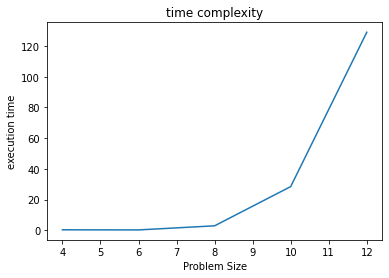

In [ ]:
#exec_time = [0.29, 0.22, 2.89, 28.43, 128.94, 38956.66]
exec_time = [0.29, 0.22, 2.89, 28.43, 128.94]
#problem_size = [4, 6, 8, 10, 12, 14]
problem_size = [4, 6, 8, 10, 12]
premutation_size = [6, 120, 5040, 362880, 39916800, 6227020800]
import matplotlib.pyplot as plt
plt.plot( problem_size, exec_time)
plt.title('time complexity')
plt.xlabel('Problem Size')
plt.ylabel('execution time')
plt.show()